In [1]:
!rm -rf dog_wolf
!rm dog_wolf.zip

rm: cannot remove 'dog_wolf.zip': No such file or directory


# 序章

In [2]:
# 必要ライブラリ・コマンドの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
w = !apt install tree
print(w[-2])

tree is already the newest version (1.7.0-5).


In [3]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# 初期設定

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

In [5]:
# デバイスの割り当て (8章)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
# 共通関数の読み込み (9章)

# 共通関数のダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

# 共通関数のロード
from pythonlibs.torch_lib1 import *

# 共通関数の存在チェック
print(README)

fatal: destination path 'pythonlibs' already exists and is not an empty directory.
Common Library for PyTorch
Author: M. Akaishi


In [7]:
# 学習用データの取り込み (12章)

# 学習用イメージのダウンロード
w = !wget https://github.com/makaishi2/pythonlibs/raw/main/images/dog_wolf.zip
print(w[-2])

# 学習用イメージの展開
w = !unzip dog_wolf.zip
print(w[-1])
 # ディレクトリ名の設定
data_dir = 'dog_wolf'

# ディレクトリ名設定
import os
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

# 分類先クラス名設定
classes = ['dog', 'wolf']

# Treeコマンド導入


# 解凍結果のツリー表示
!tree dog_wolf

2021-03-20 00:51:43 (80.4 MB/s) - ‘dog_wolf.zip’ saved [21493752/21493752]
  inflating: dog_wolf/train/wolf/wolf-09.png  
dog_wolf
├── test
│   ├── dog
│   │   ├── dog-21.png
│   │   ├── dog-22.png
│   │   ├── dog-23.png
│   │   ├── dog-24.png
│   │   └── dog-25.png
│   └── wolf
│       ├── wolf-21.png
│       ├── wolf-22.png
│       ├── wolf-23.png
│       ├── wolf-24.png
│       └── wolf-25.png
└── train
    ├── dog
    │   ├── dog-01.png
    │   ├── dog-02.png
    │   ├── dog-03.png
    │   ├── dog-04.png
    │   ├── dog-05.png
    │   ├── dog-06.png
    │   ├── dog-07.png
    │   ├── dog-08.png
    │   ├── dog-09.png
    │   ├── dog-10.png
    │   ├── dog-11.png
    │   ├── dog-12.png
    │   ├── dog-13.png
    │   ├── dog-14.png
    │   ├── dog-15.png
    │   ├── dog-16.png
    │   ├── dog-17.png
    │   ├── dog-18.png
    │   ├── dog-19.png
    │   └── dog-20.png
    └── wolf
        ├── wolf-01.png
        ├── wolf-02.png
        ├── wolf-03.png
        ├── wolf-04.png
        ├

In [8]:
# 乱数初期化　(結果を常に同じにするため)
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [9]:
# 学習用データの準備 (8章、10章、12章)

# transformの定義
# 検証データ用 : 正規化のみ実施
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

# 訓練データ用: 正規化に追加で反転とRandomErasingを実施
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)   
])

# datasetの定義
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

# dataloaderの定義
batch_size = 5
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
test_loader2 = DataLoader(test_data, batch_size=10, shuffle=False)


tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])


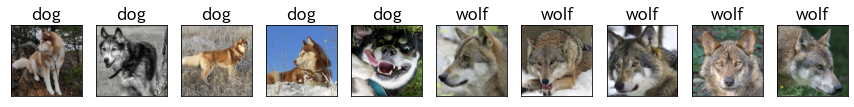

In [10]:
# 学習用データのイメージ表示 (9章)

# 訓練データを取得
for images, labels in test_loader2:
    break

print(labels)

# 最初の10個の表示

plt.figure(figsize=(15, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    image = images[i].numpy()
    label_name = classes[labels[i]]
    img = np.transpose(image, (1, 2, 0))
    img2 = (img + 1)/2 
    plt.imshow(img2)
    ax.set_title(label_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
# 学習済みモデルを利用したモデル構築 (11章)

# 学習済みモデルの読み込み
from torchvision import models
net = models.vgg19_bn(pretrained = True)

for param in net.parameters():
    param.requires_grad = False

# 最終ノードの出力を2に変更する
net.classifier[6] = nn.Linear(4096, 2)

# GPUの利用
net = net.to(device)

# 損失関数に交差エントロピーを利用
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義

# 学習率
lr = 0.001

# 重み修正の対象を最終ノードに限定
optimizer = optim.SGD(net.classifier[6].parameters(),lr=lr,momentum=0.9)

# historyファイルも同時に初期化する
history = np.zeros((0, 5))

In [12]:
# 学習の実行 (9章)

# 繰り返し回数
num_epochs = 5

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.13688 acc: 0.60000 val_loss: 0.09880, val_acc: 0.90000



Epoch [2/5], loss: 0.08077 acc: 0.85000 val_loss: 0.07423, val_acc: 0.80000



Epoch [3/5], loss: 0.03368 acc: 1.00000 val_loss: 0.04377, val_acc: 1.00000



Epoch [4/5], loss: 0.02976 acc: 0.97500 val_loss: 0.04051, val_acc: 1.00000



Epoch [5/5], loss: 0.04846 acc: 0.85000 val_loss: 0.04467, val_acc: 1.00000


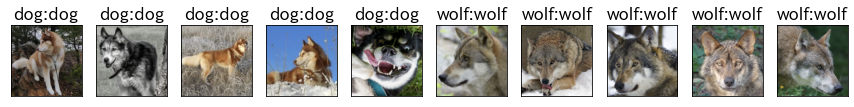

In [13]:
# 検証データを対象とした結果確認 (9章)
show_predict_result(net, test_loader2, classes, device)

# (参考)　共通関数の中身

In [13]:
from tqdm.notebook import tqdm

# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # 重み変更
            optimizer.step()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            train_acc += (predicted == labels).sum()

            # 訓練データに対する損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # 順伝搬計算
            outputs = net(inputs)

            # 誤差計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            #予測値算出
            predicted = torch.max(outputs, 1)[1]

            #正解件数算出
            val_acc += (predicted == labels).sum()

            # 検証データに対する損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history


In [14]:
# 予測結果表示
def show_predict_result(net, loader, classes, device):

    # DataLoaderから最初の1セットを取得する
    for images, labels in loader:
        break
    n_size = min(len(images), 100)

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測値の計算
    outputs = net(inputs)
    predicted = torch.max(outputs,1)[1]
    images = images.to('cpu')

    plt.figure(figsize=(15, 20))
    for i in range(n_size):
        ax = plt.subplot(10, 10, i + 1)
        image = images[i].numpy()
        label_name = classes[labels[i]]
        predicted_name = classes[predicted[i]]
        img = np.transpose(image, (1, 2, 0))
        img2 = (img + 1)/2 
        plt.imshow(img2)
        if label_name == predicted_name:
            c = 'k'
        else:
            c = 'b'
        ax.set_title(label_name + ':' + predicted_name, c=c)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()


In [12]:
# 学習の実行
# 2021-03-20 08:55 gpu
# torch.manual_seed(123)
# torch.cuda.manual_seed_all(123)

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.13688 acc: 0.60000 val_loss: 0.09880, val_acc: 0.90000



Epoch [2/5], loss: 0.08077 acc: 0.85000 val_loss: 0.07423, val_acc: 0.80000



Epoch [3/5], loss: 0.03368 acc: 1.00000 val_loss: 0.04377, val_acc: 1.00000



Epoch [4/5], loss: 0.02976 acc: 0.97500 val_loss: 0.04051, val_acc: 1.00000



Epoch [5/5], loss: 0.04846 acc: 0.85000 val_loss: 0.04467, val_acc: 1.00000


In [13]:
# 学習の実行
# 2021-03-20 08:53 gpu
# torch.manual_seed(123)
# torch.cuda.manual_seed_all(123)

num_epochs = 5
history = fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history)


Epoch [1/5], loss: 0.13688 acc: 0.60000 val_loss: 0.09880, val_acc: 0.90000



Epoch [2/5], loss: 0.08077 acc: 0.85000 val_loss: 0.07423, val_acc: 0.80000



Epoch [3/5], loss: 0.03368 acc: 1.00000 val_loss: 0.04377, val_acc: 1.00000



Epoch [4/5], loss: 0.02976 acc: 0.97500 val_loss: 0.04051, val_acc: 1.00000



Epoch [5/5], loss: 0.04846 acc: 0.85000 val_loss: 0.04467, val_acc: 1.00000
